In [1]:
from functools import partial
from fvhoe.boundary_conditions import BoundaryCondition
from fvhoe.initial_conditions import kelvin_helmholtz_2d
from fvhoe.solver import EulerSolver
from fvhoe.visualization import plot_2d_slice
import matplotlib.pyplot as plt
import numpy as np
import os
from pickle import dump, load
import sys
import warnings

warnings.filterwarnings("ignore")

sys.path.append("../../sd/src")
sys.path.append("../../sd/utils")

from initial_conditions_2d import KH_instability
from sd_simulator import SD_Simulator
import sd_visualize as sdv

In [2]:
N = 64
p = 3
T = 0.8
gamma = 1.4

n_dofs = N * (p + 1)

In [3]:
# solve with finite volumes

filename = f"kelvin-helmholtz_{N=}_{p=}"
overwrite = False

try:
    with open(f"../../snapshots/{filename}/arrs.pkl", "rb") as f:
        if overwrite:
            raise FileNotFoundError
        fv = load(f)
        print("Snapshot found!")
except FileNotFoundError:
    fv = EulerSolver(
        w0=kelvin_helmholtz_2d,
        nx=n_dofs,
        ny=n_dofs,
        px=p,
        py=p,
        riemann_solver="hllc",
        bc=BoundaryCondition(x="periodic", y="periodic"),
        gamma=gamma,
        a_posteriori_slope_limiting=True,
        slope_limiter="minmod",
        snapshot_dir="../../snapshots",
        cupy=True,
    )

    fv.rkorder(T, filename=filename, overwrite=overwrite)

Snapshot found!


Text(0.5, 0, '$x$')

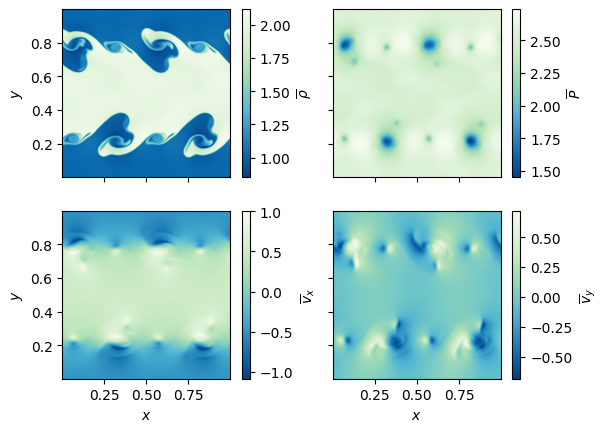

In [4]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
for var, label, idx in zip(
    ["rho", "P", "vx", "vy"],
    [r"$\overline{\rho}$", r"$\overline{P}$", r"$\overline{v}_x$", r"$\overline{v}_y$"],
    [(0, 0), (0, 1), (1, 0), (1, 1)],
):
    im = plot_2d_slice(fv, ax[idx], t=T, param=var, cmap="GnBu_r", z=0.5, verbose=False)
    fig.colorbar(im, ax=ax[idx], label=label)

ax[0, 0].set_ylabel("$y$")
ax[1, 0].set_ylabel("$y$")
ax[1, 0].set_xlabel("$x$")
ax[1, 1].set_xlabel("$x$")

In [5]:
# solve with spectral differences

filename = f"kelvin-helmholtz_{N=}_{p=}-sd"

try:
    with open(f"../../snapshots/{filename}/arrs.pkl", "rb") as f:
        sd = load(f)
    print("Snapshot found!")
except FileNotFoundError:
    sd = SD_Simulator(
        n=p,
        Nx=N,
        Ny=N,
        init_fct=KH_instability,
        BC=["periodic", "periodic"],
        detect_troubles=True,
        use_cupy=True,
    )
    sd.perform_time_evolution(T)

    # create fake snapshot
    W = sd.transpose_to_fv(sd.W_cv)

    log = dict(
        x=sd.dm.x_cv[2:-2],
        y=sd.dm.y_cv[2:-2],
        z=np.array([0.5]),
        t=sd.time.item(),
        w=np.swapaxes(W[:, ...].reshape(5, (p + 1) * N, (p + 1) * N, 1), 1, 2),
    )
    sd = [log]

    # save
    if not os.path.exists(f"../../snapshots/{filename}"):
        os.makedirs(f"../../snapshots/{filename}")
    with open(f"../../snapshots/{filename}/arrs.pkl", "wb") as f:
        dump(sd, f)

2487 time steps (t = 0.8, Execution time: 226.870609 s)874560613711435, min p = 1.5824213606080597)))


Text(0.5, 0, '$x$')

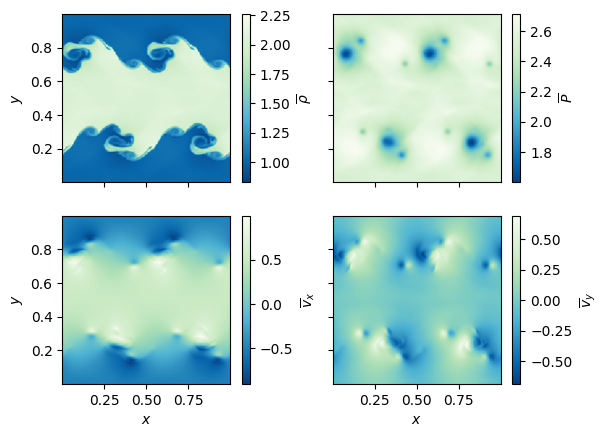

In [6]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
for var, label, idx in zip(
    ["rho", "P", "vx", "vy"],
    [r"$\overline{\rho}$", r"$\overline{P}$", r"$\overline{v}_x$", r"$\overline{v}_y$"],
    [(0, 0), (0, 1), (1, 0), (1, 1)],
):
    im = plot_2d_slice(sd, ax[idx], t=T, param=var, cmap="GnBu_r", z=0.5, verbose=False)
    fig.colorbar(im, ax=ax[idx], label=label)

ax[0, 0].set_ylabel("$y$")
ax[1, 0].set_ylabel("$y$")
ax[1, 0].set_xlabel("$x$")
ax[1, 1].set_xlabel("$x$")

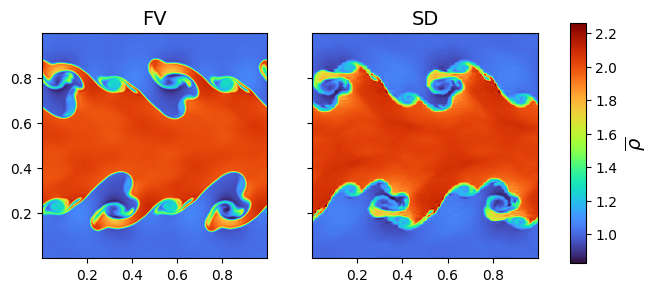

In [7]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

cmap = "turbo"
fontsize = 14

rho_min = np.min([np.min(fv[0]["w"].rho), np.min(sd[0]["w"].rho)])
rho_max = np.max([np.min(fv[0]["w"].rho), np.max(sd[0]["w"].rho)])

im0 = plot_2d_slice(
    fv,
    ax[0],
    t=T,
    param="rho",
    cmap=cmap,
    z=0.5,
    verbose=False,
    vmin=rho_min,
    vmax=rho_max,
)
im1 = plot_2d_slice(
    sd,
    ax[1],
    t=T,
    param="rho",
    cmap=cmap,
    z=0.5,
    verbose=False,
    vmin=rho_min,
    vmax=rho_max,
)

cb_ax = fig.add_axes([0.95, 0.25, 0.025, 0.5])
cb = plt.colorbar(im1, cax=cb_ax, ax=ax[1])
cb.set_label(label=r"$\overline{\rho}$", size=fontsize)

ax[0].set_title("FV", fontsize=fontsize)
ax[1].set_title("SD", fontsize=fontsize)

fig.savefig("../../kh_fv_vs_sd.png", dpi=300, bbox_inches="tight")